In [413]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import groupby
from operator import itemgetter
from sklearn.metrics import silhouette_score, confusion_matrix, f1_score, classification_report, accuracy_score
from scipy.stats import kruskal, f_oneway
from scikit_posthocs import posthoc_dunn
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import re
import cv2

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, scale
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors, metrics)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_selection import (f_classif, VarianceThreshold, chi2, mutual_info_classif, SelectKBest,
                                       SelectPercentile, f_regression, mutual_info_regression)

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold, RepeatedKFold
from sklearn.linear_model import LogisticRegression, Lasso 

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from scipy.cluster.hierarchy import dendrogram
from scipy import stats
from scipy.stats import linregress

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [414]:
analysisFolder = '/Users/sbk/Documents/IVRS/Ruta/';
picFolder = '/Users/sbk/Library/CloudStorage/Box-Box/GBM/Paper/Figs'

df2 = pd.read_excel(analysisFolder + 'MergedData.xlsx')
df2.NCells[df2.NCells == 'Low'] = 'LN';
df2.NCells[df2.NCells == 'High'] = 'HN';
df2.NCells = df2.NCells.astype('category');
df2.Mouse = df2.Mouse.astype('category');
df2 = df2[(df2.Week <= 12)];
#df2.Week = df2.Week.astype('category');
df2.Size[df2.Size == 'No Tumor'] = 'NT';
df2.Size[df2.Size == 'Medium'] = 'MS';
df2.Size[df2.Size == 'Large'] = 'LS';
df2.NormFlux[df2.NormFlux < 0] = 0;
df2.NormFlux = df2.NormFlux+1;
df2['logRadiance'] = np.log10(df2.NormFlux)
df2.MT[df2.MT == 60] = None;



In [415]:
#Remove outliers and NaNs:
df2.drop([11, 23, 44, 59, 83, 87, 103], inplace = True)
df2.dropna(subset = 'MT', inplace = True)
df2.reset_index(inplace = True, drop = True)
df2.head()

,Unnamed: 0,Mouse,Week,Date_x,NCells,DistTrav,AvgSpeed,OccCenter,OccPeri,OccRatio,...,Weight,TotalFlux,Avg-BKG Flux,Comments,MTScore,MT,NormFlux,Size,SizeScore,logRadiance
0,0,5,4,2023-02-24,Sham,180921.818774,80.722306,405,1836,0.220588,...,23.6,18780,3288.0,NaN,3,37.666667,1.0,NT,0,0.000000
1,1,4,3,2023-02-17,LN,579095.402063,107.228386,42,5334,0.007874,...,23.2,166900,13998.2,NaN,3,43.425000,13466.9,MS,1,4.129268
2,2,8,3,2023-03-07,Sham,668739.622980,123.824914,1408,3908,0.360287,...,23.5,23850,1282.0,NaN,3,43.870000,1.0,NT,0,0.000000
3,3,9,8,2023-04-11,HN,527555.148690,97.684295,0,5328,0.000000,...,24.5,930000,80746.6,NaN,3,31.906667,79797.6,MS,1,4.901990
4,4,3,5,2023-03-03,Sham,748972.592728,138.710415,458,4806,0.095298,...,22.2,16390,757.0,NaN,3,34.096667,1.0,NT,0,0.000000


In [416]:
#check for outliers in the tumor volume:
def getOutliers(data, col):
    # Calculate the interquartile range (IQR)
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1

    # Define a threshold for detecting outliers
    threshold = 1.5

    # Identify outliers
    outliers = data[(data[col] < (q1 - threshold * iqr)) | (data[col] > (q3 + threshold * iqr))]

    # Print the outliers
    #print(outliers)
    return outliers

In [417]:
len(df2[df2.logRadiance >= 2])

66

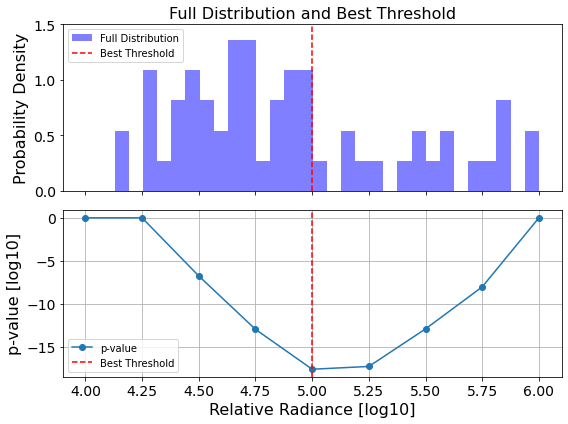

In [418]:
# Generate a sample dataset (replace with your own data)
bmin = 4
bmax = 6
step = 0.25
data = df2[(df2.logRadiance>=bmin) & (df2.logRadiance <= bmax)]['logRadiance']

# Define a range of threshold values
#threshold_values = np.linspace(np.min(data), np.max(data), num=1000)
threshold_values = np.arange(bmin, bmax+step, step)

# Initialize arrays to store p-values and means of the sub-distributions
p_values = []
means_subdist1 = []
means_subdist2 = []

# Perform threshold search analysis
for threshold in threshold_values:
    subdist1 = data[data <= threshold]
    subdist2 = data[data > threshold]
    
    if len(subdist1) > 5 and len(subdist2) > 5:  # Ensure sub-distributions have a minimum number of data points
        _, p_value = stats.ttest_ind(subdist1, subdist2)
        p_values.append(p_value)
        means_subdist1.append(np.mean(subdist1))
        means_subdist2.append(np.mean(subdist2))
    else:
        p_values.append(1.0)  # Assign a high p-value if sub-distributions are too small for the t-test

# Find the threshold value with the lowest p-value
best_threshold = threshold_values[np.argmin(p_values)]
#best_threshold = threshold_values[(np.array(p_values) < 0.05)][0]

# Plot the results
fig, ax = plt.subplots(2,1,figsize=(8, 6), sharex =  True)
hax = ax[0]
hax.hist(data, bins=30, alpha=0.5, color='blue', label='Full Distribution', density=True)
hax.axvline(x=best_threshold, color='red', linestyle='--', label='Best Threshold')
hax.legend(loc = 'upper left')
hax.set_title('Full Distribution and Best Threshold', fontsize=16)
hax.set_ylabel('Probability Density', fontsize=16)
hax.set_ylim([0, 1.5])
hax.tick_params(axis='both', labelsize=14)

hax = ax[1]
hax.plot(threshold_values, np.log10(p_values), label='p-value', marker = 'o')
hax.axvline(x=best_threshold, color='red', linestyle='--', label='Best Threshold')
hax.set_xlabel('Relative Radiance [log10]', fontsize=16)
hax.set_ylabel('p-value [log10]', fontsize=16)
hax.tick_params(axis='both', labelsize=14)
hax.legend()
hax.grid()

fname = picFolder + '/BestThreshold.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')
plt.show()


In [419]:
sizeLabels = ['NT', 'MS', 'LS'];
nLabels = ['Sham', 'LN', 'HN'];
df2['Size'] = np.repeat('NT',len(df2));
df2.Size[(df2.logRadiance >= 2) & (df2.logRadiance < best_threshold)] = 'MS';
df2.Size[(df2.logRadiance >= best_threshold)] = 'LS';


In [420]:
cbpal = sns.color_palette('colorblind', 3)
cbpal

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)]

In [421]:
def getPalette(df, labels):
    sns.set_color_codes()
    if labels == 'NCells':
        pal = {NCells: 'b' if NCells == 'LN' else ('gray' if NCells == 'HN' else 'k') for NCells in df['NCells'].unique()}
    elif labels == 'Size':
        pal = {Size: cbpal[1] if Size == 'MS' else (cbpal[2] if Size == 'LS' else cbpal[0]) for Size in df['Size'].unique()}
        
    return pal

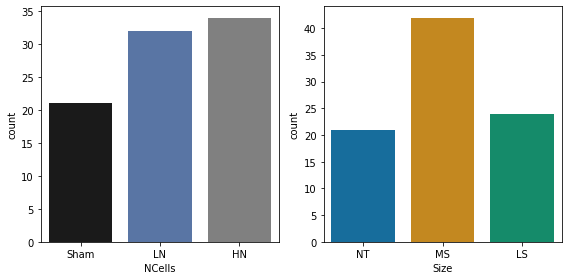

In [422]:
fig, ax = plt.subplots(1,2, figsize = (8,4));
sns.countplot(data= df2, x = 'NCells', ax = ax[0], order = ['Sham', 'LN', 'HN'], palette = getPalette(df2, 'NCells'));
sns.countplot(data= df2, x = 'Size', ax = ax[1], order = sizeLabels, palette = getPalette(df2, 'Size'));
plt.tight_layout()

LN sample does not appear to be normally distributed (reject null hypothesis)
HN sample does not appear to be normally distributed (reject null hypothesis)

Mann-Whitney U statistics: 321.0
P-value: 0.004307008741441913

LN week 3 vs HN week 3 pval = 0.007698627281707499
LN week 10 vs HN week 10 pval = 0.1078921078921079
LN week 3 vs LN week 10 pval = 0.00032908268202385847
HN week 3 vs HN week 10 pval = 0.003232062055591467
LN week 10 vs HN week 3 pval = 0.02524410573946178
LN week 3 vs HN week 10 pval = 0.0003996003996003996


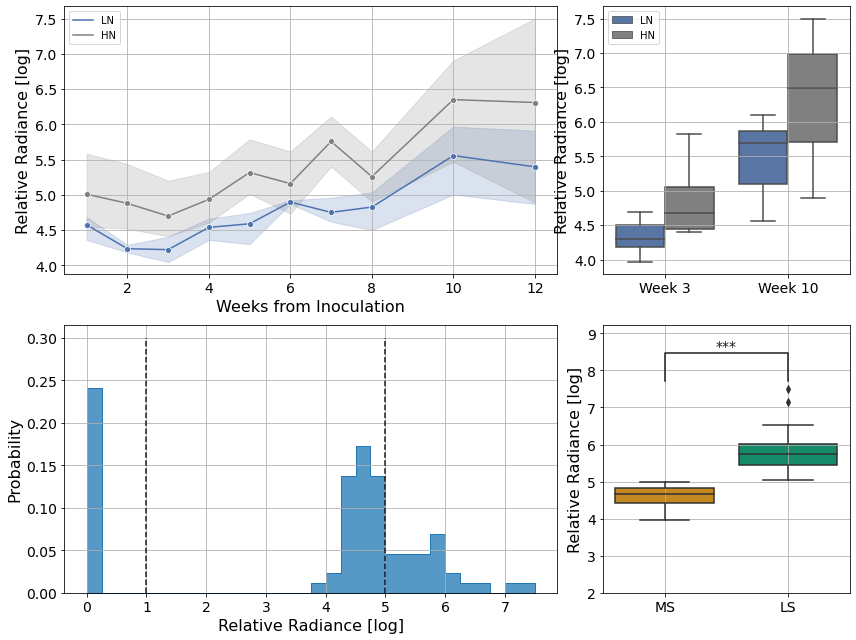

In [423]:
fig, ax = plt.subplots(2,2, figsize = (12,9), gridspec_kw={'width_ratios': [2, 1]});
h_ax = ax[0,0]
sns.set_color_codes()
bdata= df2[df2.NCells != 'Sham']
bdata.reset_index(drop = True, inplace = True)
g = sns.lineplot(data= bdata, x = 'Week', y = 'logRadiance',
                  ax = h_ax, hue = 'NCells', hue_order=['LN', 'HN'], palette = getPalette(bdata, 'NCells'), 
                  marker = 'o');
#ax.set_yscale('log')
h_ax.set_xlabel('Weeks from Inoculation', fontsize = 16)
h_ax.set_ylabel('Relative Radiance [log]', fontsize = 16)
h_ax.tick_params(axis='both', labelsize=14)
h_ax.grid()
legend = g.legend(loc='upper left')
legend.set_title(None)

# Perform the Shapiro-Wilk test to test for normality:
for bset in ['LN', 'HN']:
    stat, p = stats.shapiro(df2[(df2.NCells == bset)]['logRadiance'])
    # Check for normality (use a significance level, e.g., alpha = 0.05)
    alpha = 0.05
    if p > alpha:
        print(f'{bset} sample appears to be normally distributed (fail to reject null hypothesis)')
    else:
        print(f'{bset} sample does not appear to be normally distributed (reject null hypothesis)')

#Statistics for 'LN' and 'HN' groups
data_ln = df2[(df2.NCells == 'LN')]['logRadiance']
data_hn = df2[(df2.NCells == 'HN')]['logRadiance']
statistic, p_value = stats.mannwhitneyu(data_ln, data_hn, alternative='two-sided')
# Output results
print(f"\nMann-Whitney U statistics: {statistic}")
print(f"P-value: {p_value}\n")
    
#comparison 1st vs 12th week:
WK1 = 3
WK2 = 10    
dummy = df2[(df2.Week <= WK1) | (df2.Week >= WK2)];
dummy['WeekL'] = np.repeat('Week 1', len(dummy));
dummy.WeekL[dummy.Week <= WK1] = f'Week {WK1}';
dummy.WeekL[dummy.Week >= WK2] = f'Week {WK2}';
dummy = dummy[dummy.NCells != 'Sham'];
dummy.reset_index(drop = True, inplace=True)


var = 'logRadiance';
h_ax = ax[0,1]
g = sns.boxplot(data=dummy, x = 'WeekL', y=var, ax=h_ax, hue='NCells', hue_order = ['LN', 'HN'], order=[f'Week {WK1}', f'Week {WK2}'], palette = getPalette(dummy, 'NCells'))
h_ax.set_xticks([0,1])
h_ax.set_xticklabels([f'Week {WK1}', f'Week {WK2}'])
h_ax.set_xlabel(None)
h_ax.set_ylabel('Relative Radiance [log]', fontsize=16)
h_ax.tick_params(axis='both', labelsize=14)
h_ax.grid()
g.legend_.set_title(None)

# Perform the Mann-Whitney U test
set1 = dummy[(dummy.NCells == 'LN') & (dummy.Week <= WK1)][var]
set2 = dummy[(dummy.NCells == 'HN') & (dummy.Week <= WK1)][var]
statistic, p_value = stats.mannwhitneyu(set1, set2)
print(f'LN week {WK1} vs HN week {WK1} pval = {p_value}');

# Perform the Mann-Whitney U test
set1 = dummy[(dummy.NCells == 'LN') & (dummy.Week >= WK2)][var]
set2 = dummy[(dummy.NCells == 'HN') & (dummy.Week >= WK2)][var]
statistic, p_value = stats.mannwhitneyu(set1, set2)
print(f'LN week {WK2} vs HN week {WK2} pval = {p_value}');

set1 = dummy[(dummy.NCells == 'LN') & (dummy.Week <= WK1)][var]
set2 = dummy[(dummy.NCells == 'LN') & (dummy.Week >= WK2)][var]
statistic, p_value = stats.mannwhitneyu(set1, set2)
print(f'LN week {WK1} vs LN week {WK2} pval = {p_value}');

set1 = dummy[(dummy.NCells == 'HN') & (dummy.Week <= WK1)][var]
set2 = dummy[(dummy.NCells == 'HN') & (dummy.Week >= WK2)][var]
statistic, p_value = stats.mannwhitneyu(set1, set2)
print(f'HN week {WK1} vs HN week {WK2} pval = {p_value}');  

set1 = dummy[(dummy.NCells == 'LN') & (dummy.Week >= WK2)][var]
set2 = dummy[(dummy.NCells == 'HN') & (dummy.Week <= WK1)][var]
statistic, p_value = stats.mannwhitneyu(set1, set2)
print(f'LN week {WK2} vs HN week {WK1} pval = {p_value}');

set1 = dummy[(dummy.NCells == 'LN') & (dummy.Week <= WK1)][var]
set2 = dummy[(dummy.NCells == 'HN') & (dummy.Week >= WK2)][var]
statistic, p_value = stats.mannwhitneyu(set1, set2)
print(f'LN week {WK1} vs HN week {WK2} pval = {p_value}');    

#Histogram of Radiance:
h_ax = ax[1,0]
sns.histplot(data= df2, x = 'logRadiance', bins = 30, stat = 'probability', log_scale = False, kde =  False, ax = h_ax, element = 'step', palette = 'b');
h_ax.vlines(x = 1, ymin = 0, ymax = 0.3, color = 'k', linestyle='--')
h_ax.vlines(x = best_threshold, ymin = 0, ymax = 0.3, color = 'k', linestyle='--')
h_ax.tick_params(axis='both', labelsize=14)
h_ax.set_ylabel('Probability', fontsize = 16)
h_ax.set_xlabel('Relative Radiance [log]', fontsize = 16)
h_ax.grid()

#comparison medium and large size tumors:
# Perform the Mann-Whitney U test
var = 'logRadiance';
medium_size = df2[df2.Size == 'MS'][var]
large_size = df2[df2.Size == 'LS'][var]
statistic, p_value = stats.mannwhitneyu(medium_size, large_size)

# Annotate the plot with the significance level
if p_value < 0.05:  # Assuming a significance level of 0.05
    significance = "*"
    if p_value <= 0.001:
        significance = "**";
    if p_value <= 0.0001:
        significance = "***" 
else:
    significance = "ns"  # Not significant

h_ax = ax[1,1]
dummy = df2[df2.Size != 'NT'];
dummy.reset_index(drop = True, inplace=True)

var = 'logRadiance';
sns.boxplot(data=dummy, x='Size', y=var, ax=h_ax, order=['MS', 'LS'], palette = getPalette(dummy, 'Size'))
#ax.set_yscale('log')
h_ax.set_xlabel(None)
h_ax.set_ylabel('Relative Radiance [log]', fontsize=16)
h_ax.grid()
g.legend_.set_title(None)

# Annotate the plot with the significance level
x1, x2 = 0, 1  # Positions of the boxplot groups
y =  dummy[var].max() * 1.03;
h, col = dummy[var].max() * 0.1, 'k'  # Position and style of the significance annotation
h_ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
h_ax.text((x1 + x2) * .5, y + h, significance, ha='center', va='bottom', color=col, fontsize=14)
h_ax.set_ylim([2, y + 2*h])
h_ax.tick_params(axis='both', labelsize=14)

fname = picFolder + '/TumorGrowth.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')
plt.show()

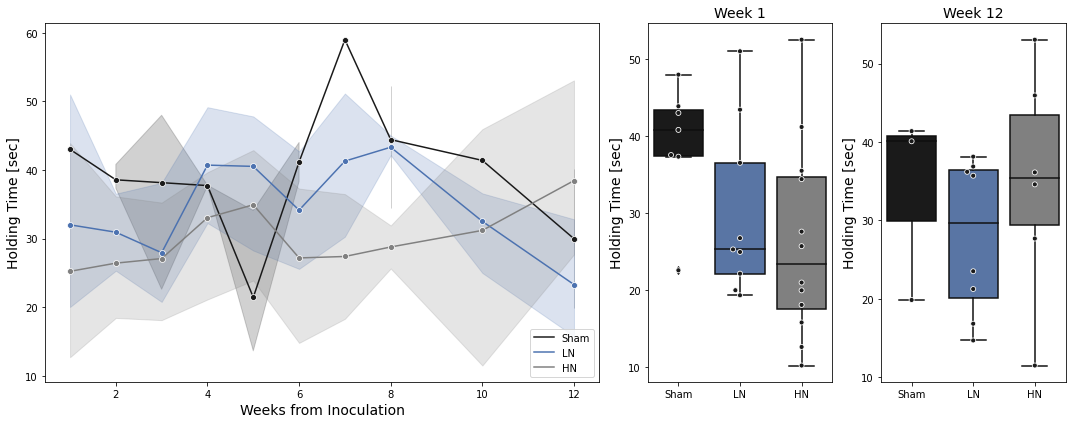

In [424]:
fig, ax = plt.subplots(1,3, figsize = (15,6), gridspec_kw={'width_ratios': [3, 1, 1]});

g = sns.lineplot(data= df2, x = 'Week', y = 'MT', ax = ax[0], hue = 'NCells', hue_order=nLabels, palette = getPalette(df2, 'NCells'),  marker = 'o');
ax[0].set_ylabel('Holding Time [sec]', fontsize = 14)
ax[0].set_xlabel('Weeks from Inoculation', fontsize = 14)
g.legend_.set_title(None)
ax[0].legend(loc='lower right')

sns.boxplot(data= df2[(df2.Week <= 3)],  y = 'MT', ax = ax[1], x = 'NCells', order=nLabels, palette = getPalette(df2, 'NCells'));
sns.swarmplot(data= df2[(df2.Week <= 3)],  y = 'MT', ax = ax[1], x = 'NCells', order=nLabels, color = 'k', edgecolor = 'white', linewidth=0.8, dodge=True);
ax[1].set_ylabel('Holding Time [sec]', fontsize = 14)
ax[1].set_xlabel(' ', fontsize = 14)
ax[1].set_title('Week 1', fontsize = 14)

sns.boxplot(data= df2[(df2.Week >= 10)], y = 'MT', ax = ax[2], x = 'NCells', order=nLabels, palette = getPalette(df2, 'NCells'));
sns.swarmplot(data= df2[(df2.Week >= 10)],  y = 'MT', ax = ax[2], x = 'NCells', order=nLabels, color = 'k', edgecolor = 'white', linewidth=0.8, dodge=True);
ax[2].set_ylabel('Holding Time [sec]', fontsize = 14)
ax[2].set_xlabel(' ', fontsize = 14)
ax[2].set_title('Week 12', fontsize = 14)


fname = picFolder + '/MT_ncells.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='white', edgecolor='auto')
plt.show()

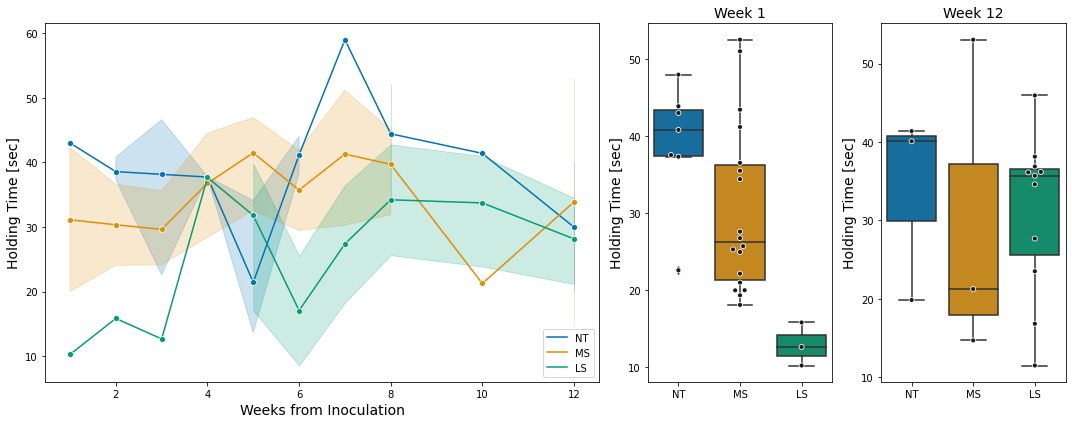

In [425]:
fig, ax = plt.subplots(1,3, figsize = (15,6), gridspec_kw={'width_ratios': [3, 1, 1]});
#g = sns.pointplot(data= df2, x = 'Week', y = 'MT', ax = ax[0], hue = 'Size', hue_order=sizeLabels, capsize = 0.1, palette = getPalette(df2, 'Size'));
g = sns.lineplot(data= df2, x = 'Week', y = 'MT', ax = ax[0], hue = 'Size', hue_order=sizeLabels, marker = 'o', palette = getPalette(df2, 'Size'));
ax[0].set_ylabel('Holding Time [sec]', fontsize = 14)
ax[0].set_xlabel('Weeks from Inoculation', fontsize = 14)
g.legend_.set_title(None)
ax[0].legend(loc='lower right')

sns.boxplot(data= df2[(df2.Week <= 3)],  y = 'MT', ax = ax[1], x = 'Size', order=sizeLabels, palette = getPalette(df2, 'Size'));
sns.swarmplot(data= df2[(df2.Week <= 3)],  y = 'MT', ax = ax[1], x = 'Size', order=sizeLabels, color = 'k', edgecolor = 'white', linewidth=0.8, dodge=True);
ax[1].set_ylabel('Holding Time [sec]', fontsize = 14)
ax[1].set_xlabel(' ', fontsize = 14)
ax[1].set_title('Week 1', fontsize = 14)

sns.boxplot(data= df2[(df2.Week >= 10)], y = 'MT', ax = ax[2], x = 'Size', order=sizeLabels, palette = getPalette(df2, 'Size'));
sns.swarmplot(data= df2[(df2.Week >= 10)],  y = 'MT', ax = ax[2], x = 'Size', order=sizeLabels, color = 'k', edgecolor = 'white', linewidth=0.8, dodge=True);
ax[2].set_ylabel('Holding Time [sec]', fontsize = 14)
ax[2].set_xlabel(' ', fontsize = 14)
ax[2].set_title('Week 12', fontsize = 14)


fname = picFolder + '/MT_size.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='white', edgecolor='auto')
plt.show()

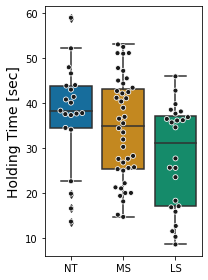

In [426]:
fig, ax = plt.subplots(1,1, figsize = (3,4));

#sns.boxplot(data = df2[(df2.Week == 7) |(df2.Week == 8) | (df2.Week == 9) | (df2.Week == 10) | (df2.Week == 11) | (df2.Week == 12)], x = 'Size', y = 'MT', ax = ax, palette = 'colorblind', order = sizeLabels);
sns.boxplot(data = df2, x = 'Size', y = 'MT', ax = ax, palette = getPalette(df2, 'Size'), order = sizeLabels);
sns.swarmplot(data = df2, x = 'Size', y = 'MT', ax = ax, color = 'k', edgecolor = 'white', linewidth=0.8, dodge = True);
ax.set_ylabel('Holding Time [sec]', fontsize = 14)
ax.set_xlabel(None)

fname = picFolder + '/MT_distrsize.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')
plt.show()


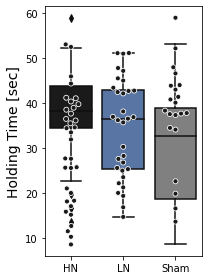

In [427]:
fig, ax = plt.subplots(1,1, figsize = (3,4));

sns.boxplot(data = df2, x = 'NCells', y = 'MT', ax = ax, palette = getPalette(df2, 'NCells'), order = nLabels);
sns.swarmplot(data = df2, x = 'NCells', y = 'MT', ax = ax, color = 'k', edgecolor = 'white', linewidth=0.8, dodge = True);
ax.set_ylabel('Holding Time [sec]', fontsize = 14)
ax.set_xlabel(None)

fname = picFolder + '/MT_distrNcells.png'    
#plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')
plt.tight_layout()
plt.show()


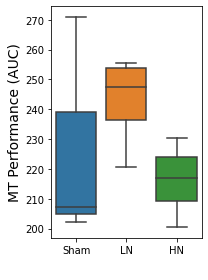

In [428]:
fig, ax = plt.subplots(1,1, figsize = (3,4));

auc = [];
ttx = [];

mice = np.unique(df2.Mouse[df2.NCells == 'Sham']);
for ix in range(len(mice)):
    auc.append(np.trapz(df2.MT[df2.Mouse == mice[ix]]));
    ttx.append('Sham')
    
mice = np.unique(df2.Mouse[df2.NCells == 'LN']);
for ix in range(len(mice)):
    auc.append(np.trapz(df2.MT[df2.Mouse == mice[ix]]));
    ttx.append('LN')
    
mice = np.unique(df2.Mouse[df2.NCells == 'HN']);
for ix in range(len(mice)):
    auc.append(np.trapz(df2.MT[df2.Mouse == mice[ix]]));
    ttx.append('HN')

dummy = pd.DataFrame({'AUC': auc, 'Ttx': ttx});    

sns.boxplot(data = dummy, x = 'Ttx', y = 'AUC', ax = ax);
ax.set_ylabel('MT Performance (AUC)', fontsize = 14)
ax.set_xlabel(' ', fontsize = 14)

fname = picFolder + '/MT_performance.png'    
plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')
plt.tight_layout()

plt.show();    

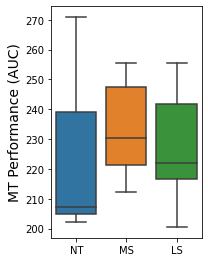

In [429]:
fig, ax = plt.subplots(1,1, figsize = (3,4));

auc = [];
ttx = [];

mice = np.unique(df2.Mouse[df2.Size == 'NT']);
for ix in range(len(mice)):
    auc.append(np.trapz(df2.MT[df2.Mouse == mice[ix]]));
    ttx.append('NT')
    
mice = np.unique(df2.Mouse[df2.Size == 'MS']);
for ix in range(len(mice)):
    auc.append(np.trapz(df2.MT[df2.Mouse == mice[ix]]));
    ttx.append('MS')
    
mice = np.unique(df2.Mouse[df2.Size == 'LS']);
for ix in range(len(mice)):
    auc.append(np.trapz(df2.MT[df2.Mouse == mice[ix]]));
    ttx.append('LS')

dummy = pd.DataFrame({'AUC': auc, 'Ttx': ttx});    

sns.boxplot(data = dummy, x = 'Ttx', y = 'AUC', ax = ax);
ax.set_ylabel('MT Performance (AUC)', fontsize = 14)
ax.set_xlabel(' ', fontsize = 14)

fname = picFolder + '/MT_performanceSize.png'    
plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')
plt.tight_layout()

plt.show();    

In [430]:
#sns.pairplot(data= pcaDf, hue = 'Size')
#sns.pairplot(data= pcaDf[pcaDf.PC2 < 2.5], hue = 'Size')
#plt.show()

This procedure does ot capture the actual classes used in this study

## Behavior Panel:

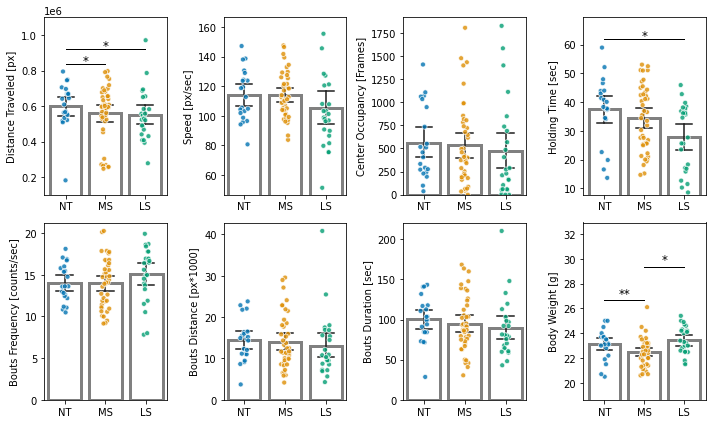

In [431]:
def runKruskal(df, var, ax, sizeLabels):
    # Identify and remove outliers using IQR method
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
    
    #df_filtered = df;
    
    #kruskal_result = f_oneway(*[df_filtered[var][df_filtered['Size'] == size] for size in df_filtered['Size'].unique()])
    kruskal_result = kruskal(*[df_filtered[var][df_filtered['Size'] == size] for size in df_filtered['Size'].unique()])
    if kruskal_result.pvalue < 0.05:
        posthoc = posthoc_dunn(df_filtered, val_col=var, group_col='Size')
        #posthoc = posthoc_dunn(df_filtered, val_col=var, group_col='Size')
        vals = posthoc.values
        sizeLabels = df_filtered['Size'].unique()
        
        # Find significant pairs and annotate the plot with the significance level        
        line_y = df_filtered[var].max()*1.05
        
        # Bonferroni correction: Adjust the significance threshold
        bonferroni_alpha = 0.05 / (len(sizeLabels) * (len(sizeLabels) - 1) / 2)
        
        for ix in range(len(sizeLabels)):
            for ij in range(ix + 1, len(sizeLabels)):
                p_value = vals[ix, ij]
                if p_value < bonferroni_alpha:
                    significance = "*"
                    if p_value <= 0.001:
                        significance = "**";
                    if p_value <= 0.0001:
                        significance = "***"                     
                    x_pos = (ix + ij) / 2
                    ax.text(x_pos, line_y * 1.02, significance, ha='center', va='center', fontsize=12)
                    ax.plot([ix, ij], [line_y, line_y], color='black', linestyle='-', linewidth=1)
                    line_y = line_y * 1.1
        ax.set_ylim([df2[var].min() / 1.1, line_y * 1.02])
    

fig, ax = plt.subplots(2,4,figsize = (10,6))

var = 'DistTrav'
h_ax = ax[0,0];
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels,
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
h_ax.set_ylim([0.1e6, 1.1e6])
h_ax.set_ylabel('Distance Traveled [px]');

var = 'AvgSpeed'
h_ax = ax[0,1];
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
h_ax.set_ylabel('Speed [px/sec]');

var = 'OccCenter'
h_ax = ax[0,2];
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
#h_ax.set_ylim([0, 0.8])
h_ax.set_xlabel(None);
h_ax.set_ylabel('Center Occupancy [Frames]');

var = 'BoutsFreq'
h_ax = ax[1,0]
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
h_ax.set_ylabel('Bouts Frequency [counts/sec]');

var = 'BoutsDist'
h_ax = ax[1,1]
dummy = df2.copy();
dummy[var] = dummy[var]/1000;
sns.barplot(data= dummy, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = dummy, x = 'Size', y = var, ax = h_ax, palette = getPalette(dummy, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(dummy, var, h_ax, sizeLabels)
ax[1,1].set_xlabel(None);
ax[1,1].set_ylabel('Bouts Distance [px*1000]');

var = 'BoutsDur'
h_ax = ax[1,2]
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
h_ax.set_ylabel('Bouts Duration [sec]');

var = 'MT'
h_ax = ax[0,3]
#sel = (df2.Week == 1) | (df2.Week == 2) | (df2.Week == 3) | (df2.Week == 4) 
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
h_ax.set_ylabel('Holding Time [sec]');

var = 'Weight'
h_ax = ax[1,3]
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor= 'k',errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
h_ax.set_ylabel('Body Weight [g]');

fname = picFolder + '/Beh_Panel.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')

plt.show();  

## Distribution of behavioral data 

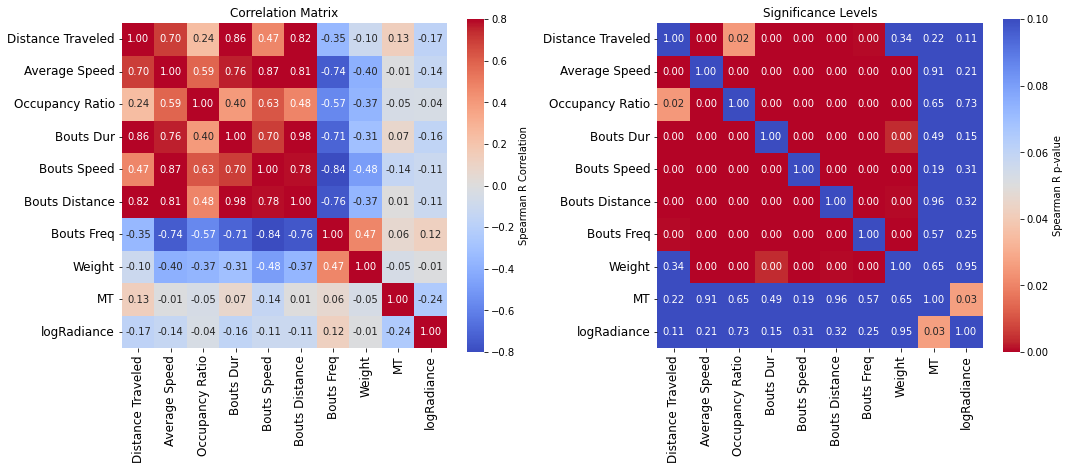

In [262]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def calculate_p_values(data):
    _, num_features = data.shape
    p_values = np.zeros((num_features, num_features))

    for i in range(num_features):
        for j in range(num_features):
            if i == j: 
                p_values[i, j] = 1
            else:
                corr, p_value = pearsonr(data.iloc[:, i], data.iloc[:, j])
                p_values[i, j] = p_value

    return p_values

# Correlation matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Calculate correlation matrix
scaler = StandardScaler()
features = ['DistTrav', 'AvgSpeed', 'OccRatio', 'BoutsDur', 'BoutsVel', 'BoutsDist', 'BoutsFreq', 'Weight','MT', 'logRadiance']
X = df2.loc[:, features]
X.rename(columns = {'DistTrav': 'Distance Traveled', 'AvgSpeed':'Average Speed',
                    'OccRatio': 'Occupancy Ratio', 
                    'BoutsDist': 'Bouts Distance', 
                    'BoutsFreq': 'Bouts Freq', 
                    'BoutsDur':'Bouts Dur', 
                    'BoutsVel': 'Bouts Speed'}, inplace = True)

#result = scaler.fit_transform(X)
#X = pd.DataFrame(result, columns = features)
c_matrix = pd.DataFrame.corr(X.astype('float'), method = 'pearson')

# Plot correlation matrix heatmap
sns.heatmap(c_matrix, annot=True, fmt='.2f', ax=ax1, cmap='coolwarm', vmin=-0.8, vmax=0.8, 
            square=True, cbar_kws={"shrink": .82, 'label': 'Spearman R Correlation'})
ax1.set_title('Correlation Matrix')
ax1.tick_params(axis='both', labelsize=12)

# Plot significance levels
p_values = calculate_p_values(X)  # Replace with your own function to calculate p-values
significance_levels = np.zeros_like(c_matrix)
significance_levels[p_values < 0.01] = 1  # Set significance level as 1 for p-values < 0.05
c_matrix = pd.DataFrame(p_values, columns = features)
cmap_reversed = plt.cm.get_cmap('coolwarm_r')
sns.heatmap(c_matrix, annot=True, fmt='.2f', cmap = cmap_reversed, cbar=True, ax=ax2, 
            vmin = 0, vmax = 0.1, xticklabels= list(X.columns), yticklabels= list(X.columns), 
            square=True, cbar_kws={"shrink": .82, 'label': 'Spearman R p-value'})
ax2.set_title('Significance Levels')
ax2.tick_params(axis='both', labelsize=12)
#ax2.set_yticklabels(features)
# Adjust the layout to make room for the second subplot
#plt.subplots_adjust(wspace=0.5)

# Save and show the plot
fname = picFolder + '/CorrMatrix2.tiff'
# Save and show the plot
plt.tight_layout()
plt.savefig(fname, dpi= 200, format='tiff',
        bbox_inches= 'tight', pad_inches=0.1, facecolor='white', edgecolor= None)
plt.show()

## Machine Learning models:

In [263]:
#to plot the output performance of the models:
def plotReg(y,y_pred,hax):
    bcolor = np.ones(len(y))
    bcolor[(y>0) & (y<5)] = 2
    bcolor[(y>=5)] = 3
    dummy = pd.DataFrame({'y': y, 'y_pred': y_pred, 'Size': bcolor})
        
    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Calculate p-value
    slope, intercept, r_value, p_value, std_err = linregress(y, y_pred)

    # Plot:
    sns.regplot(data=dummy, x='y', y='y_pred', ax = hax, x_ci= 'ci', ci = 95)
    sns.scatterplot(data=dummy, x='y', y='y_pred', ax=hax, hue='Size', s=100)
    hax.set_xlabel('Actual Values', fontsize = 14)
    hax.set_ylabel('Predicted Values', fontsize = 14)

    coef = np.polyfit(y, y_pred, 1)
    poly1d_fn = np.poly1d(coef)
    hax.plot(y, poly1d_fn(y), 'b-', label = f'Trend Line: r = {r_value:.2f}; p = {p_value:.2f}')
    hax.plot(y, y, 'r', label = 'Perfect Match')
    hax.legend(title = None, loc = 'upper left')

    # Add box annotation
    bbox_props = dict(boxstyle="round", fc="white", ec="gray", alpha=0.8)
    #textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f} \nMAE: {mae:.2f} \nMBD: {mbd:.2f} \n$R^2$: {r2:.2f} \nAdj $R^2$: {adjusted_r2:.2f} \np-value: {p_value:.3f}'
    textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f} \nMAE: {mae:.2f} \n$R^2$: {r2:.2f}\n'
    hax.text(0.8, 0.05, textstr, transform=hax.transAxes, fontsize=10, verticalalignment='bottom', bbox=bbox_props)
    hax.tick_params(axis='both', labelsize=12)
    hax.grid(True)


In [295]:
def resample_boot(X,y, n = 2):
    # Set the number of times you want to bootstrap the data
    num_bootstrap_samples = n  # Increase the dataset size by a factor of 3

    # Initialize arrays to store augmented data
    augX = []
    augy = []

    # Perform bootstrapping to augment the data
    for _ in range(num_bootstrap_samples):
        # Randomly select indices with replacement
        indices = np.random.choice(len(X), len(X), replace=False)
        
        # Use the selected indices to create augmented datasets
        augX.append(X[indices])
        augy.append(y[indices])

    # Concatenate the bootstrapped data
    augX = np.vstack(augX)
    augy = np.hstack(augy)
    
    return augX, augy

In [317]:
# Extract the features (independent variables) and the target (dependent variable)
y = df2.logRadiance;
bX = df2.drop(columns = ['NormFlux', 'logRadiance', 'Mouse', 'Unnamed: 0', 'NCells', 'Date_x', 'Date_y', 'Week',
                        'OccCenter', 'OccPeri', 'Group', 'Batch', 'Treatment', 'TotalFlux', 'Avg-BKG Flux',
                        'Comments', 'MTScore', 'Size', 'SizeScore', 'Weight'])
bX.reset_index(drop = True, inplace = True);
features_names = list(bX.columns);


X = StandardScaler().fit_transform(bX)


![Alt text](https://scikit-learn.org/stable/_images/grid_search_workflow.png "model training workflow")

https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics

In [326]:
#Data augmentation?
#augX, augy = resample_boot(X,y)

# Feature selection (you can customize this step)
selector = SelectKBest(f_regression, k=4)
kf = RepeatedKFold(n_splits=5, n_repeats = 2, random_state=42)
X2 = selector.fit_transform(X, y)

#Display selected features:
cols_idx = selector.get_support(indices=True)
print('Selected Features:')
for ix in cols_idx:
    print(f'- {features_names[ix]}')

    
    
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=42)

# Models to evaluate
models = [
    ('LR', LinearRegression()),
    ('LLR', Lasso()),
    ('KNN', KNeighborsRegressor()),
    ('RF', RandomForestRegressor()),
    ('DT', DecisionTreeRegressor()),
    ('GB', GradientBoostingRegressor()),
    ('XGB', XGBRegressor()),
]

print('\nTraining:')
bModels = [] #to collect the best models
for model_name, model in models:
    model_pipeline = Pipeline([
        ('feature_selection', selector),
        ('model', model)
    ])

    # Hyperparameter tuning using Grid Search and Cross-Validation
    param_grid = {}
    if model_name == 'GB':
        param_grid = {
            'model__n_estimators': [100, 500, 1000],
            'model__max_depth': [3, 5, 6],
            'model__max_features': [3, 5, 7],
            'model__learning_rate': [1, 0.1, 0.01]
        }
    elif model_name == 'XGB':
        param_grid = {
            'model__n_estimators': [100, 500, 1000],
            'model__max_depth': [3, 5, 6],
            'model__learning_rate': [1, 0.1, 0.01]
        }
    elif model_name == 'RF':
        param_grid = {
            'model__n_estimators': [100, 500, 1000],
            'model__max_depth': [3, 5, 6],
            'model__max_features': [3, 5, 7],
        }
    elif model_name == 'DT':
        param_grid = {
            'model__max_depth': [3, 5, 6],
            'model__max_features': [3, 5, 7],
        }
    elif model_name == 'LLR':
        param_grid = {
            'model__alpha': [1, 0.5, 0.1],
        }
    elif model_name == 'KNN':
        param_grid = {
            'model__n_neighbors': [1, 3, 5, 10, 20],
        }

    print(f'- Current model: {model_name}\n', end="\r")

    grid_search = GridSearchCV(model_pipeline, param_grid, cv=kf, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    bModels.append([model_name, best_model, best_params])
    

Selected Features:
- DistTrav
- AvgSpeed
- BoutsDur
- MT

Training:
- Current model: LR
- Current model: LLR
- Current model: KNN
- Current model: RF
- Current model: DT
- Current model: GB
- Current model: XGB


Model: LR
Best Parameters: {}
Mean Squared Error: 6.21014111524222
R-squared (R²): -0.17380181772465408


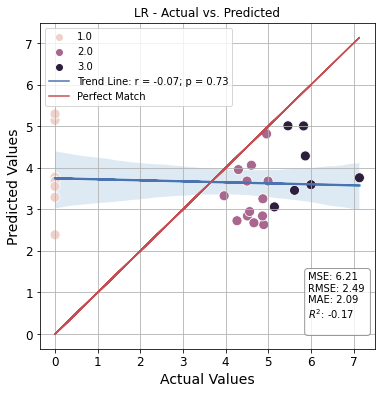

Model: LLR
Best Parameters: {'model__alpha': 0.1}
Mean Squared Error: 5.560466825989517
R-squared (R²): -0.051004469403197694


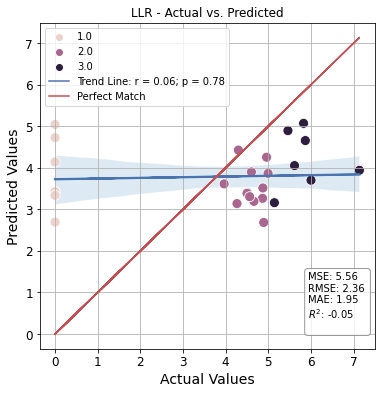

Model: KNN
Best Parameters: {'model__n_neighbors': 5}
Mean Squared Error: 4.9355429934900314
R-squared (R²): 0.06711470323958724


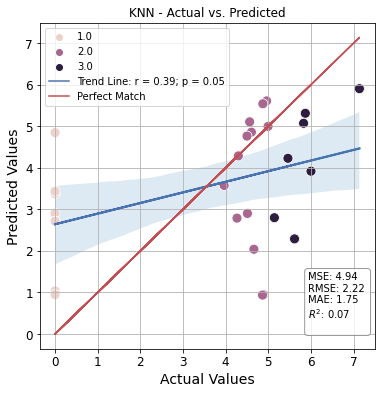

Model: RF
Best Parameters: {'model__max_depth': 6, 'model__max_features': 3, 'model__n_estimators': 100}
Mean Squared Error: 5.8258708817967655
R-squared (R²): -0.10116947489291483


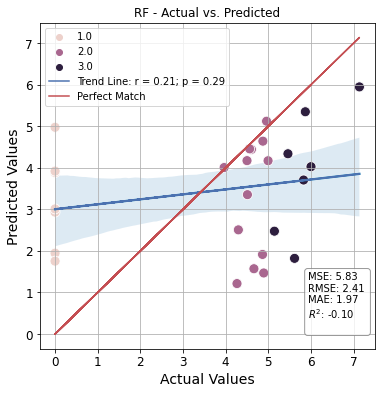

Model: DT
Best Parameters: {'model__max_depth': 3, 'model__max_features': 3}
Mean Squared Error: 6.226635845231643
R-squared (R²): -0.17691954785109854


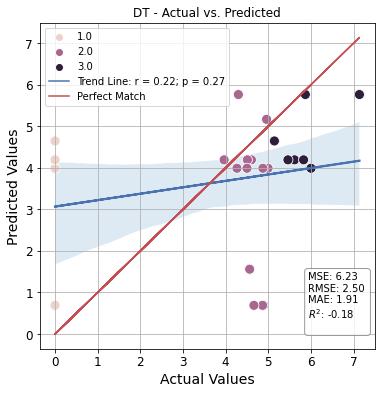

Model: GB
Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__max_features': 3, 'model__n_estimators': 100}
Mean Squared Error: 5.5094857420354275
R-squared (R²): -0.04136834553670332


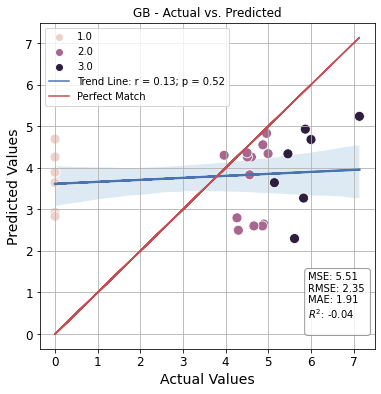

Model: XGB
Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 500}
Mean Squared Error: 7.474809884586329
R-squared (R²): -0.41284155494289854


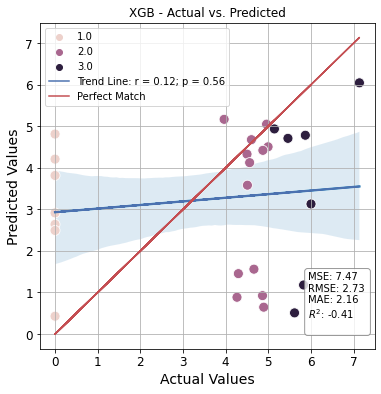

In [327]:
# Make predictions and calculate metrics
for model_name, best_model, best_params in bModels:
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print and visualize results
    print(f'Model: {model_name}')
    print(f'Best Parameters: {best_params}')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared (R²): {r2}')

    fig, ax = plt.subplots(1,1,figsize=(6, 6))
    plotReg(y_test,y_pred,ax)
    plt.title(f"{model_name} - Actual vs. Predicted")
    plt.show()

In [336]:
y = np.zeros(len(df2))
y[df2.Size == 'MS'] = 1
y[df2.Size == 'LS'] = 2

bX = df2.drop(columns = ['NormFlux', 'logRadiance', 'Mouse', 'Unnamed: 0', 'NCells', 'Date_x', 'Date_y', 'Week',
                        'OccCenter', 'OccPeri', 'Group', 'Batch', 'Treatment', 'TotalFlux', 'Avg-BKG Flux',
                        'Comments', 'MTScore', 'Size', 'SizeScore', 'Weight'])
bX.reset_index(drop = True, inplace = True);
features_names = list(bX.columns);
X = StandardScaler().fit_transform(bX)

#augX, augy = resample_boot(X,y)
selector = SelectKBest(f_classif, k=4)
X2 = selector.fit_transform(X, y)

#Display selected features:
cols_idx = selector.get_support(indices=True)
print('Selected Features:')
for ix in cols_idx:
    print(f'- {features_names[ix]}')

Selected Features:
- AvgSpeed
- BoutsFreq
- BoutsVel
- MT


In [337]:
y = np.zeros(len(df2))
y[df2.Size == 'MS'] = 1
y[df2.Size == 'LS'] = 2

bX = df2.drop(columns = ['NormFlux', 'logRadiance', 'Mouse', 'Unnamed: 0', 'NCells', 'Date_x', 'Date_y', 'Week',
                        'OccCenter', 'OccPeri', 'Group', 'Batch', 'Treatment', 'TotalFlux', 'Avg-BKG Flux',
                        'Comments', 'MTScore', 'Size', 'SizeScore', 'Weight'])
bX.reset_index(drop = True, inplace = True);
features_names = list(bX.columns);
X = StandardScaler().fit_transform(bX)

#augX, augy = resample_boot(X,y)
selector = SelectKBest(f_classif, k=4)
X2 = selector.fit_transform(X, y)

#Display selected features:
cols_idx = selector.get_support(indices=True)
print('Selected Features:')
for ix in cols_idx:
    print(f'- {features_names[ix]}')
    
    
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

kf = RepeatedKFold(n_splits=5, n_repeats = 2, random_state=42)

# Models to evaluate
models = [
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('RF', RandomForestClassifier()),
    ('DT', DecisionTreeClassifier()),
    ('GB', GradientBoostingClassifier()),
    ('XGB', XGBClassifier()),
]

bModels2 = [] #to collect the best models

# Evaluate and visualize models
for model_name, model in models[0:5]:
    model_pipeline = Pipeline([
        ('feature_selection', selector),
        ('model', model)
    ])

    # Hyperparameter tuning using Grid Search and Cross-Validation
    param_grid = {}
    if model_name == 'GB':
        param_grid = {
            'model__n_estimators': [100, 500, 1000],
            'model__max_depth': [3, 5, 6],
            'model__max_features': [3, 5, 7],
            'model__learning_rate': [1, 0.1, 0.01]
        }
    elif model_name == 'XGB':
        param_grid = {
            'model__n_estimators': [100, 500, 1000],
            'model__max_depth': [3, 5, 6],
            'model__learning_rate': [1, 0.1, 0.01]
        }
    elif model_name == 'RF':
        param_grid = {
            'model__n_estimators': [100, 500, 1000],
            'model__max_depth': [3, 5, 6],
            'model__max_features': [3, 5, 7],
        }
    elif model_name == 'DT':
        param_grid = {
            'model__max_depth': [3, 5, 6],
            'model__max_features': [3, 5, 7],
        }
    elif model_name == 'LLR':
        param_grid = {
            'model__alpha': [1, 0.5, 0.1],
        }
    elif model_name == 'KNN':
        param_grid = {
            'model__n_neighbors': [1, 3, 5, 10, 20],
        }

    print(f'Current model: {model_name}\n', end="\r")

    grid_search = GridSearchCV(model_pipeline, param_grid, cv=kf, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    bModels2.append([model_name, best_model, best_params])

Selected Features:
- AvgSpeed
- BoutsFreq
- BoutsVel
- MT
Current model: LR
Current model: KNN
Current model: RF
Current model: DT
Current model: GB


Accuracy: 44.44%


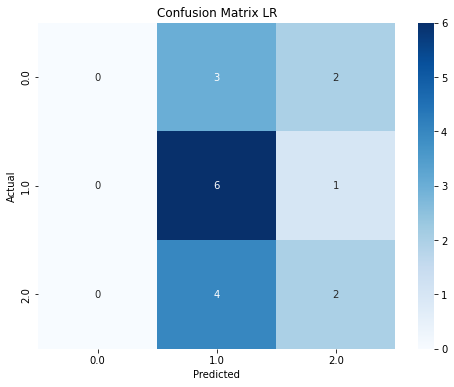

Accuracy: 33.33%


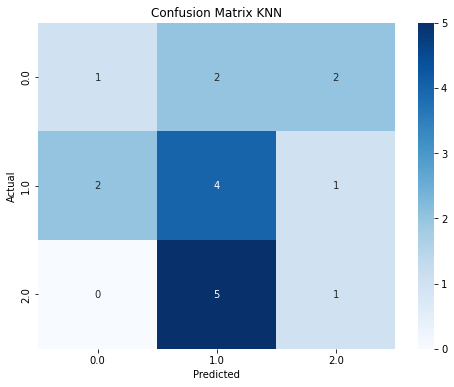

Accuracy: 38.89%


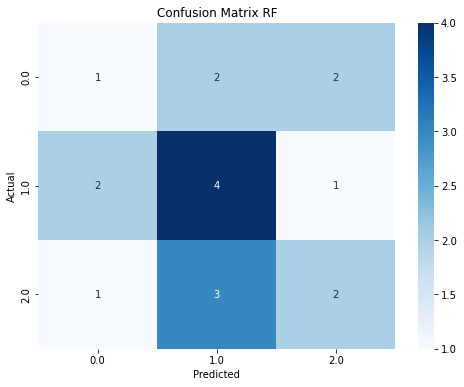

Accuracy: 50.00%


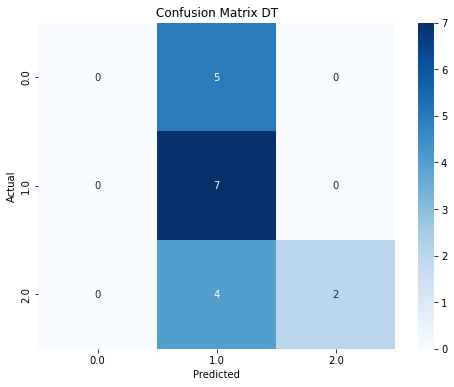

Accuracy: 55.56%


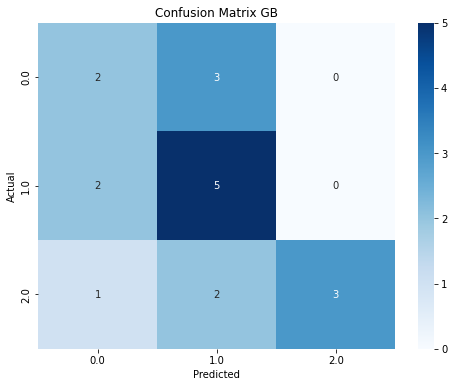

In [338]:
# Make predictions and calculate metrics
for model_name, best_model, best_params in bModels2:
    best_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = best_model.predict(X_test)

    # Evaluate the model's accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Create a confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Plot a heatmap of the confusion matrix
    class_names = np.unique(y)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix {model_name}')
    plt.show()

    

In [305]:
# Import PCA from scikit-learn
from sklearn.decomposition import PCA

y = np.zeros(len(df2))
y[df2.Size == 'MS'] = 1
y[df2.Size == 'LS'] = 2

bX = df2.drop(columns = ['NormFlux', 'logRadiance', 'Mouse', 'Unnamed: 0', 'NCells', 'Date_x', 'Date_y', 'Week',
                        'OccCenter', 'OccPeri', 'Group', 'Batch', 'Treatment', 'TotalFlux', 'Avg-BKG Flux',
                        'Comments', 'MTScore', 'Size', 'SizeScore', 'Weight'])
bX.reset_index(drop = True, inplace = True);
features_names = list(bX.columns);
X = StandardScaler().fit_transform(bX)

n_components = 3  # Number of principal components to retain
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

#augX, augy = resample_boot(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
kf = RepeatedKFold(n_splits=5, n_repeats = 2, random_state=42)


# Models to evaluate
models = [
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('RF', RandomForestClassifier()),
    ('DT', DecisionTreeClassifier()),
    ('GB', GradientBoostingClassifier()),
    ('XGB', XGBClassifier()),
]

bModels2 = []  # to collect the best models

# Evaluate and visualize models
for model_name, model in models:
    model_pipeline = Pipeline([
        ('pca', pca),  # Use PCA-transformed data
        ('model', model)
    ])

    # Hyperparameter tuning using Grid Search and Cross-Validation
    param_grid = {}
    if model_name == 'GB':
        param_grid = {
            'model__n_estimators': [100, 500, 1000],
            'model__max_depth': [3, 5, 6],
            'model__max_features': [3, 5, 7],
            'model__learning_rate': [1, 0.1, 0.01]
        }
    elif model_name == 'XGB':
        param_grid = {
            'model__n_estimators': [100, 500, 1000],
            'model__max_depth': [3, 5, 6],
            'model__learning_rate': [1, 0.1, 0.01]
        }
    elif model_name == 'RF':
        param_grid = {
            'model__n_estimators': [100, 500, 1000],
            'model__max_depth': [3, 5, 6],
            'model__max_features': [3, 5, 7],
        }
    elif model_name == 'DT':
        param_grid = {
            'model__max_depth': [3, 5, 6],
            'model__max_features': [3, 5, 7],
        }
    elif model_name == 'LLR':
        param_grid = {
            'model__alpha': [1, 0.5, 0.1],
        }
    elif model_name == 'KNN':
        param_grid = {
            'model__n_neighbors': [1, 3, 5, 10, 20],
        }

    print(f'Current model: {model_name}\n', end="\r")

    grid_search = GridSearchCV(model_pipeline, param_grid, cv=kf, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    bModels2.append([model_name, best_model, best_params])

Current model: LR
Current model: KNN
Current model: RF
Current model: DT
Current model: GB
Current model: XGB


Accuracy: 27.78%


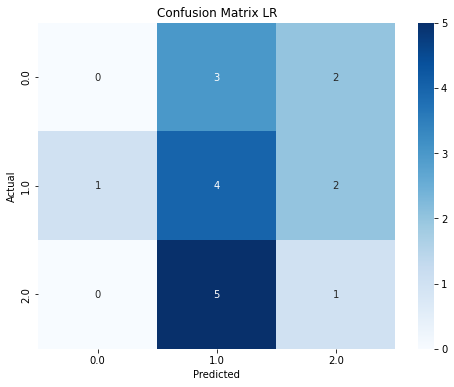

Accuracy: 33.33%


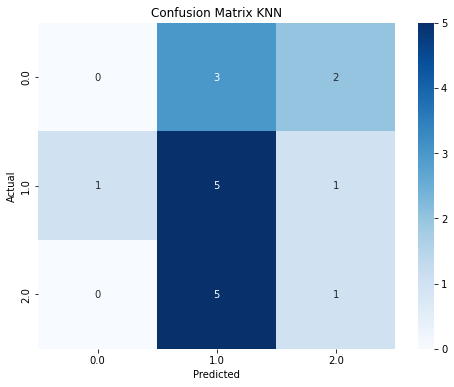

Accuracy: 38.89%


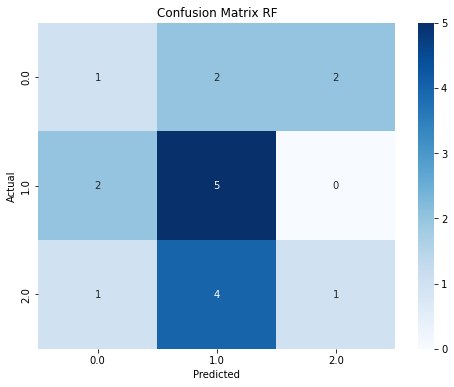

Accuracy: 38.89%


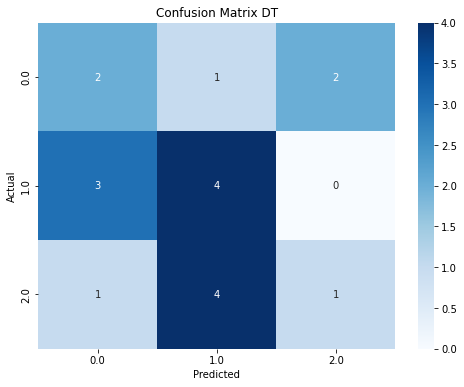

Accuracy: 38.89%


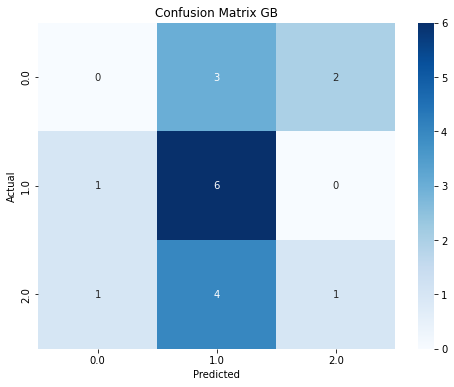

Accuracy: 27.78%


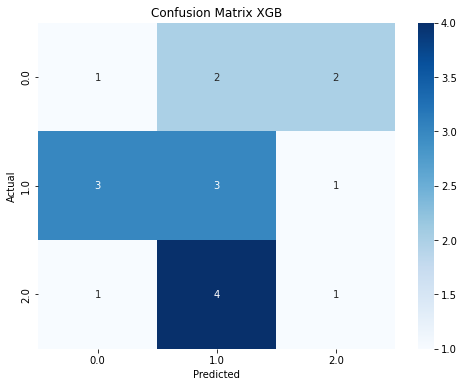

In [307]:
# Make predictions and calculate metrics
for model_name, best_model, best_params in bModels2:
    best_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = best_model.predict(X_test)

    # Evaluate the model's accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Create a confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Plot a heatmap of the confusion matrix
    class_names = np.unique(y)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix {model_name}')
    plt.show()

The choice of the evaluation metric to determine the best model depends on the specific problem you are trying to solve and the characteristics of your dataset. Here's a brief explanation of when to use each of the mentioned metrics:

1. **Mean Squared Error (MSE)**: MSE is a common choice for regression problems. It measures the average squared difference between the predicted values and the actual values. Lower MSE indicates better model performance. MSE is sensitive to outliers and gives more weight to larger errors.

2. **Root Mean Squared Error (RMSE)**: RMSE is the square root of the MSE. It has the same interpretation as the original data's units, which can make it easier to understand. Like MSE, lower RMSE values indicate better performance. RMSE is also sensitive to outliers.

3. **R-squared (R2)**: R-squared measures the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features). It ranges from 0 to 1, with higher values indicating better model fit. R-squared of 1 means the model explains all the variance, while an R-squared of 0 means it doesn't explain any.

The choice between these metrics depends on your specific goals:

- Use **MSE or RMSE** when you want to directly measure the accuracy of your model's predictions in terms of the original data scale. These metrics are appropriate if you want to penalize larger errors more heavily.

- Use **R2** when you want to understand how well your model explains the variance in the target variable. It provides a measure of goodness of fit. R2 is particularly useful when you need to compare different models or assess how much of the variability in the target variable is captured by your model.

In practice, it's often a good idea to consider multiple metrics to get a more comprehensive view of your model's performance. For example, you might look at both RMSE and R2 to assess predictive accuracy and model fit simultaneously.

Ultimately, the choice of the best metric depends on your specific problem and what aspect of model performance you want to prioritize.

https://www.graphpad.com/support/faq/andnbspwhy-do-many-data-points-lie-outside-the-regression-confidence-bands/